In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, classifier, utils

2024-02-27 19:33:18.145702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 19:33:18.145763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 19:33:18.146585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 19:33:18.153448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 19:33:19.043929: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:1000]}
#['1012', '1383', '1385', '1386', '1471', '1473', '1474'],

In [3]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

input_features_reduced_further = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)']
input_features_new = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)',
                  'Argument of Periapsis (deg)', 'True Anomaly (deg)']
label_features=['EW', 'EW_Type', 'EW_Node', 'EW_Node_Location', 'NS', 'NS_Type', 'NS_Node', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      exclude_objects=[],
                                      non_transform_features=['Eccentricity',
                                                              'Semimajor Axis (m)',
                                                              'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              #'Argument of Periapsis (deg)',
                                                              'True Anomaly (deg)',
                                                              'Latitude (deg)',
                                                              #'Longitude (deg)',
                                                              ],
                                      diff_transform_features=['Eccentricity',
                                                               'Semimajor Axis (m)',
                                                               'Inclination (deg)',
                                                               'RAAN (deg)',
                                                               'Argument of Periapsis (deg)',
                                                               'True Anomaly (deg)',
                                                               #'Longitude (deg)',
                                                               'Latitude (deg)'
                                                               ],
                                      sin_transform_features=[ #'Inclination (deg)',
                                                               #'RAAN (deg)',
                                                               'Argument of Periapsis (deg)',
                                                               #'True Anomaly (deg)',
                                                               'Longitude (deg)',
                                                               #'Latitude (deg)'
                                                              ],
                                      sin_cos_transform_features=[
                                                               #'Inclination (deg)',
                                                               #'RAAN (deg)',
                                                               #'Argument of Periapsis (deg)',
                                                               #'True Anomaly (deg)',
                                                               #'Longitude (deg)',
                                                               #'Latitude (deg)'
                                                               ],
                                      overview_features_mean=['Eccentricity',
                                                              'Semimajor Axis (m)',
                                                              'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              'Argument of Periapsis (sin)',
                                                              #'True Anomaly (deg)',
                                                              #'Latitude (deg)',
                                                              'Longitude (sin)',
                                                              ],
                                      overview_features_std=['Latitude (deg)',
                                                             'Argument of Periapsis (sin)'
                                                             ],
                                      add_daytime_feature=False,
                                      add_yeartime_feature=False,
                                      add_linear_timeindex=True,
                                      with_labels=True,
                                      train_val_split=0.8,
                                      input_stride=1,
                                      padding='zero',
                                      unify_value_ranges=True,
                                      scale=True,
                                      per_object_scaling=False,
                                      pad_location_labels=0,
                                      input_history_steps=16,
                                      input_future_steps=128,
                                      input_dtype=np.float32,
                                      sort_inputs=True,
                                      seed=11,
                                      deepcopy=True)


=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: zero
Horizons: 16-128 @ stride 1
Scaling: True  
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Sin-Transforming features: ['Argument of Periapsis (deg)', 'Longitude (deg)']
Sin-Cos-Transforming features: []
Diff Transforming features: ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)']
Adding linear timeindex.
Final 24 input features: ['Argument of Periapsis (deg) (diff)', 'Argument of Periapsis (sin)', 'Eccentricity', 'Eccentricity (diff)', 'Inclination (deg)', 'Inclination (deg) (diff)', 'Latitude (deg)', 'Latitude (deg) (diff)', 'LinearTimeIndex', 'Longitude (sin)', 'RAAN (deg)', 'RAAN (deg) (diff)', 'Semimajor Axis (m)', 'Semimajor Axis (m) (diff)', 'True Anomaly (deg)', 'True Anomaly (deg) (diff)'] + overview of ['Argument of Periapsis (sin)', 'Eccent

In [38]:
utils.set_random_seed(42)

train_combined, val_combined = ds_gen.get_datasets(batch_size=512, 
                                                   label_features=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                                   with_identifier=False, 
                                                   only_nodes=False, 
                                                   shuffle=True, 
                                                   stride=1,
                                                   keep_label_stride=300,
                                                   verbose=1)
print(train_combined.element_spec)
# Cardinality is below number of nodes, because sometimes EW and NS are in the same location

  1%|          | 9/1520 [00:00<00:17, 83.99it/s]

100%|██████████| 380/380 [00:04<00:00, 86.62it/s]


Train-DS Cardinality: tf.Tensor(15928, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(3996, shape=(), dtype=int64)
(TensorSpec(shape=(None, 144, 24), dtype=tf.float32, name=None), {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 144, 24)]            0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 68, 48)               10416     ['Input[0][0]']               
                                                                                                  
 activation_5 (Activation)   (None, 68, 48)               0         ['conv1d_3[0][0]']            
                                                                                                  
 dropout_5 (Dropout)         (None, 68, 48)               0         ['activation_5[0][0]']        
                                                                                            

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0.5653727054595947,
 0.17127396166324615,
 0.1437205821275711,
 0.9429429173469543,
 0.9579579830169678]

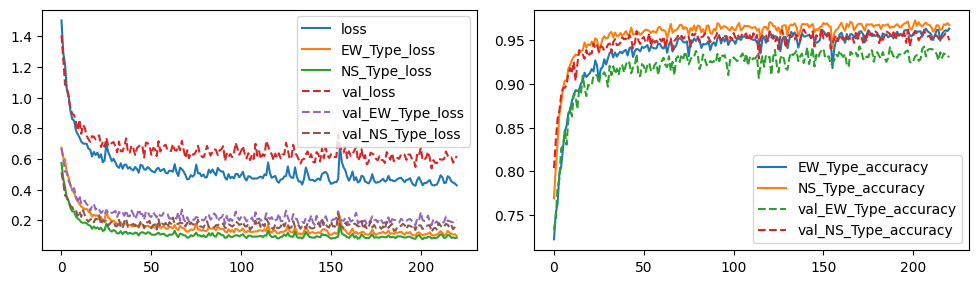

In [39]:
utils.set_random_seed(42)

#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[16], l2_reg=0.0001, input_dropout=0.1, mixed_dropout=0.5, lr_scheduler=[10000,0.9], seed=0)
#dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[1], l2_reg=0.00001, mixed_dropout=0.2, lr_scheduler=[70000,0.9], seed=0)

dense_model = prediction_models.Dense_NN(val_combined,
                                         conv1d_layers=[[48,9,2,1,1],[48,5,1,1,1],[48,3,1,1,1]],
                                         convlstm1d_layers=[],#[[16,4],[16,4],[16,4]],
                                         conv2d_layers=[],#[32,(6,3)],[32,(6,3)],[32,(6,3)]],
                                         dense_layers=[64,32],
                                         lstm_layers=[],
                                         l2_reg=0.001,
                                         input_dropout=0.00,
                                         mixed_dropout_dense=0.05,
                                         mixed_dropout_cnn=0.1,
                                         mixed_dropout_lstm=0.0,
                                         mixed_batchnorm=False, # if True, this fucks up inference big time! maybe re-visit?
                                         lr_scheduler=[0.005],#, 250, 0.9],
                                         output_type='classification',
                                         seed=0)

#dense_model._model = create_timeseries_classification_model((65,6))

dense_model.summary()

# temporary fix to allow class weights
# train_combined= train_combined.map(lambda x,y:(x,y[f'EW_Type']))
# val_combined = val_combined.map(lambda x,y:(x,y[f'EW_Type'])) 

# w_0 = 1.05
# w_1 = 1.2
# w_2 = 1.05
# w_3 = 0.65

hist = dense_model.fit(train_combined,
                       val_ds=val_combined,
                       epochs=500,
                       verbose=2,
                       plot_hist=True,
                       save_best_only=True,
                       early_stopping=50,
                       target_metric='val_EW_Type_accuracy',
                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                       callbacks=[])
dense_model.evaluate(val_combined)
#dense_model.model.save('models/ew_ns_classifier_new.hdf5')

In [ ]:
hist = dense_model.fit(train_combined, val_ds=val_combined, early_stopping=40, target_metric='val_EW_Type_accuracy', epochs=100, verbose=2, plot_hist=True, callbacks=[])

In [6]:
#dense_model.model.save('submission/models/ew_ns_classifier.hdf5')

In [ ]:
ds_gen.plot_dataset_items(val_combined)

In [40]:
pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=dense_model,
                                train=False,
                                test=False,
                                model_outputs=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                object_limit=None,
                                only_nodes=True,
                                confusion_matrix=False,
                                prediction_batches=3,
                                verbose=1)

1/1 [==============================] - 0s 18ms/step


In [41]:
ground_truth_df = pd.read_csv(challenge_data_dir / 'train_labels.csv')#.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
# TEMPORARY: remove erronous keys from gt
ground_truth_df=ground_truth_df.loc[((~ground_truth_df['ObjectID'].isin([1012, 1383, 1385, 1386, 1471, 1473, 1474]) & ground_truth_df['Node'] != 'ES'))].copy()
ground_truth_df['Node'] = 'UNKNOWN'
ground_truth_df['Type'] = 'UNKNOWN'

typed_df = classifier.fill_unknown_types_based_on_preds(pred_df, ground_truth_df, dirs=['EW', 'NS'])
classified_df = classifier.fill_unknwon_nodes_based_on_type(typed_df, dirs=['EW', 'NS'])

# ground_truth_df=ground_truth_df.loc[ground_truth_df['TimeIndex']==0]
# majority_df=majority_df.loc[majority_df['TimeIndex']==0]
# ground_truth_df=ground_truth_df.loc[ground_truth_df['Direction']=='EW']
# majority_df=majority_df.loc[majority_df['Direction']=='EW']

# 0.95 with 3-layer cnn and 128@2 horizon

# EW: 0.965, 996 36
# NS: 0.967, 782 27
ground_truth_eval_df = pd.read_csv(challenge_data_dir / 'train_labels.csv')
evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_eval_df, participant=classified_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
print(f'Precision: {precision:.3f}')
print(f'TP: {total_tp} FP: {total_fp}')

Precision: 0.954
TP: 1755 FP: 85


In [29]:
ground_truth_df.loc[((ground_truth_df['ObjectID'] == 1143) & (ground_truth_df['TimeIndex'] == 1033)), 'Type'] = 'NK'
ground_truth_df.loc[((ground_truth_df['ObjectID'] == 1143) & (ground_truth_df['TimeIndex'] == 1033)), 'Node'] = 'ID'
print(pred_df.loc[pred_df['ObjectID'] == 111].head(20))
tmp = classifier.fill_unknown_types_based_on_preds(pred_df, ground_truth_df, dirs=['EW', 'NS'])
print(tmp.loc[tmp['ObjectID'] == 1143].head(20))
tmp = classifier.fill_unknwon_nodes_based_on_type(tmp, dirs=['EW', 'NS'])
print(tmp.loc[tmp['ObjectID'] == 1143].head(20))

    ObjectID  TimeIndex  EW_Type_Pred EW_Type  NS_Type_Pred NS_Type Type Node
21       111          0             3      NK             3      NK   na   na
22       111        124             3      NK             3      NK   na   na
23       111        411             3      NK             3      NK   NK   ID
24       111        418             3      NK             3      NK   na   na
25       111        479             2      HK             2      HK   na   na
      ObjectID  TimeIndex Direction     Node Type
1176      1143          0        EW  UNKNOWN   NK
1177      1143          0        NS  UNKNOWN   NK
1178      1143       1026        EW  UNKNOWN   NK
1179      1143       1033        EW       ID   NK
1180      1143       1082        NS  UNKNOWN   CK
1181      1143       1729        EW  UNKNOWN   NK
1182      1143       1729        NS  UNKNOWN   NK
      ObjectID  TimeIndex Direction Node Type
1176      1143          0        EW   SS   NK
1177      1143          0        NS   SS

In [16]:
print(total_df.loc[(total_df['classification']=='FP') & (total_df['matched']==True)].head(50))

      ObjectID  TimeIndex Direction Node Type classification distance matched
6            3          0        EW   SS   EK             FP        0    True
27          12          0        EW   SS   EK             FP        0    True
28          12          0        NS   SS   CK             FP        0    True
40          17          0        EW   SS   EK             FP        0    True
41          17          0        NS   SS   CK             FP        0    True
69          30          0        NS   SS   CK             FP        0    True
166         78          0        NS   SS   CK             FP        0    True
179         84          0        NS   SS   CK             FP        0    True
192         90          0        NS   SS   CK             FP        0    True
207         97          0        NS   SS   CK             FP        0    True
216        101          0        NS   SS   CK             FP        0    True
745        212        622        NS   IK   CK             FP    

In [45]:
test = range(10)
tmp_df = pd.DataFrame({'time':range(10), 'node' : 'blue'})
tmp_df2 = pd.DataFrame({'time':[5,7], 'node' : 'bla'})
tmp_df = pd.concat([tmp_df, tmp_df2]).reset_index(drop=True)

duplicate_indices = tmp_df.duplicated(subset=['time'], keep=False) # returns index of all duplicates
tmp_df.loc[duplicate_indices==True, 'node'] = 'UNKNOWN'
duplicate_indices_keep_first = tmp_df.duplicated(subset=['time'], keep='first') # returns index of all duplicates except the first
print(duplicate_indices_keep_first)
print(duplicate_indices_keep_first.sum())
print(len(duplicate_indices_keep_first))
tmp_df = tmp_df[duplicate_indices_keep_first==False]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11     True
dtype: bool
2
12


In [20]:
print(dense_model.model.optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.005>


In [9]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_oneshot_cnn.pkl', 'wb'))
dense_model.model.save('submission/models/ew_ns_classifier_oneshot_cnn.hdf5')

#0.12 0.92 0.950 (no dropout, strong overfitting, no ft-transform)

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
